In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import matplotlib.image as imageio
import shutil
import zipfile

from scipy import ndimage
from tensorflow.keras import regularizers
from urllib.request import urlretrieve
from scipy.io import loadmat

tf.keras.backend.set_floatx('float32')

train_dir = "train"
val_dir = "val"
test_dir = "test"

# Download data

In [ ]:
def download_file(url, path):
    print("Downloading from %s" % url)
    zip_path = path + ".zip"
    urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("")
    os.remove(zip_path)  
    
download_file("https://storage.googleapis.com/kagglesdsdata/competitions/3362/31148/test1.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586455286&Signature=oS7Fn9tB7KyNGUL3AYhy%2Bu8v37g4wLyeNEl%2BG5f%2BjX2J4JprknIdxzrnn4dKICgT8XChG%2Bglp2NvV0ZbRSsDrUQ9EjRAnpJW%2BMUGYjtDChu3lJ5zcAae9fwYLmcJ1qmhQgNL4Wl5zx8FHR%2FWf9A%2BJaHwITBSlMcOsV%2F1ISwdnKgUTSGys8XlRrykqHm41lCA1t1%2FBo0OHLc68AEph%2FCFSvKC%2BmHkmytVLKw2j3nwyU2oAvoU91MB7Vvu52PsqzKEjVWkW%2Fn8dUonQApgCBvVQwVGfWXC5uAyAx%2BArUhDptW%2By7DKp7VpqjrjQevknjhxCVMZgRP0%2Fal1MSI8Hkw0KA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest1.zip", "test")
download_file("https://storage.googleapis.com/kagglesdsdata/competitions/3362/31148/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586723425&Signature=F3w4rcUihV%2F67w7XwAS5e1PTaDmlNZLgUW8OQrDBXpr%2BR8qWi%2BYdsZgxK9Es22PQODjU%2BiwVKA1dxXpFbJYmMRLK095WotTicMGExZVUPA1PFfmDOwsAXpJfSa6clfhS9ai0Q0IfH8%2BGOmy%2F916x1Wy0KhN%2Bppx8fGc0aSCkyQ19iYOHGCk3Ok8tk2UJHviViuaHMnPzxBDAse0v9XhSOkL9ehSBsqKF9tSqocY%2FgXqZ969LHi6ROaI7sV%2B3u6RtqNw3cDwuhUcslsHT9f724nh5EZdoxp%2B0V9Y9YAJikb81k3a%2FaPQkyHKPzVg1Bx7M%2FdhIAmUrvZe%2FFJ3Maq5J8Q%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip", "train")

In [ ]:
os.mkdir(val_dir)
os.mkdir(test_dir)

os.mkdir(train_dir + "/dog")
os.mkdir(train_dir + "/cat")

os.mkdir(val_dir + "/dog")
os.mkdir(val_dir + "/cat")

os.mkdir(test_dir + "/dog")
os.mkdir(test_dir + "/cat")

val_size = 1000
test_size = 2000

image_files = os.listdir(train_dir)
for i, file in enumerate(image_files):
    if "jpg" not in file:
        continue
        
    animal, im_id, _ = file.split('.')
    if i <= val_size:
        subfolder = val_dir
    elif i <= val_size + test_size:
        subfolder = test_dir
    else:
        subfolder = train_dir

    os.rename(train_dir + "/" + file, subfolder + "/" + animal + "/" + file)

# Verify data

total training cat images: 9500
total training dog images: 9499
--
total validation cat images: 1000
total validation dog images: 1001
--
total test cat images: 2000
total test dog images: 2000
--
Total training images: 18999
Total validation images: 2001
Total test images: 4000
Found 18999 images belonging to 2 classes.
Found 2001 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


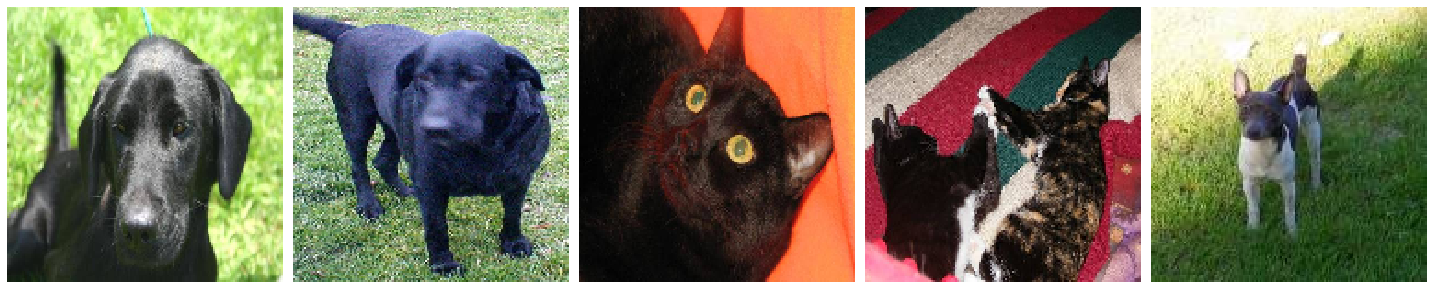

In [2]:
num_cats_tr = len(os.listdir(os.path.join(train_dir, 'cat') ))
num_dogs_tr = len(os.listdir(os.path.join(train_dir, 'dog')))

num_cats_val = len(os.listdir(os.path.join(val_dir, 'cat') ))
num_dogs_val = len(os.listdir(os.path.join(val_dir, 'dog') ))

num_cats_test = len(os.listdir(os.path.join(test_dir, 'cat')))
num_dogs_test = len(os.listdir(os.path.join(test_dir, 'dog')))


total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
total_test = num_dogs_test + num_cats_test

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)
print("--")
print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print('total test cat images:', num_cats_test)
print('total test dog images:', num_dogs_test)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total test images:", total_test)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32 
IMG_HEIGHT = 150
IMG_WIDTH = 150

train_image_generator = ImageDataGenerator(rescale=1./255) 
val_image_generator = ImageDataGenerator(rescale=1./255) 
test_image_generator = ImageDataGenerator(rescale=1./255) 

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

val_data_gen = val_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=val_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=test_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

def plot_images(images):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
sample_training_images, _ = next(train_data_gen)
plot_images(sample_training_images[:5])

# Simple classification model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    
    Conv2D(256, 3, activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    
    Flatten(),
    
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)      

In [6]:
history = model.fit_generator(train_data_gen,
                   steps_per_epoch=150,
                   epochs=10,
                   validation_data=val_data_gen,
                   validation_steps=50,
                   verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 150 steps, validate for 50 steps
Epoch 1/10
150/150 [==============================] - 135s 898ms/step - loss: 0.7284 - accuracy: 0.5118 - val_loss: 0.6869 - val_accuracy: 0.5281
Epoch 2/10
150/150 [==============================] - 121s 808ms/step - loss: 0.6797 - accuracy: 0.5723 - val_loss: 0.6421 - val_accuracy: 0.6144
Epoch 3/10
150/150 [==============================] - 120s 803ms/step - loss: 0.6282 - accuracy: 0.6458 - val_loss: 0.5738 - val_accuracy: 0.6963
Epoch 4/10
150/150 [==============================] - 118s 790ms/step - loss: 0.5848 - accuracy: 0.6933 - val_loss: 0.5595 - val_accuracy: 0.7356
Epoch 5/10
150/150 [==============================] - 123s 822ms/step - loss: 0.5600 - accuracy: 0.7188 - val_loss: 0.5277 - val_accuracy: 0.7581
Epoch 6/10
150/150 [==============================] - 122s 816ms/step - loss: 0.5510 - accuracy: 0.7231 - val_loss: 0.5143 - val_accuracy: 0.7606
Epoch 7/10
150/150 [===========

  ...
    to  
  ['...']
125/125 [==============================] - 22s 179ms/step - loss: 0.4410 - accuracy: 0.7915


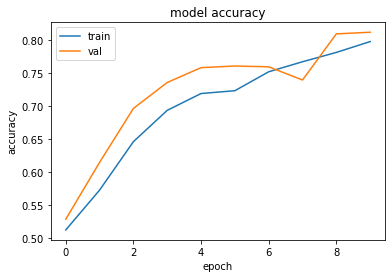

In [8]:
model.evaluate(test_data_gen)

def plot_history(history):
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(history)

# Image augmentation

In [9]:
BATCH_SIZE = 32 

train_augmented_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

val_augmented_get = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_aug_data_gen = train_augmented_gen.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

val_aug_data_gen = val_augmented_get.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=val_dir, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

Found 18999 images belonging to 2 classes.
Found 2001 images belonging to 2 classes.


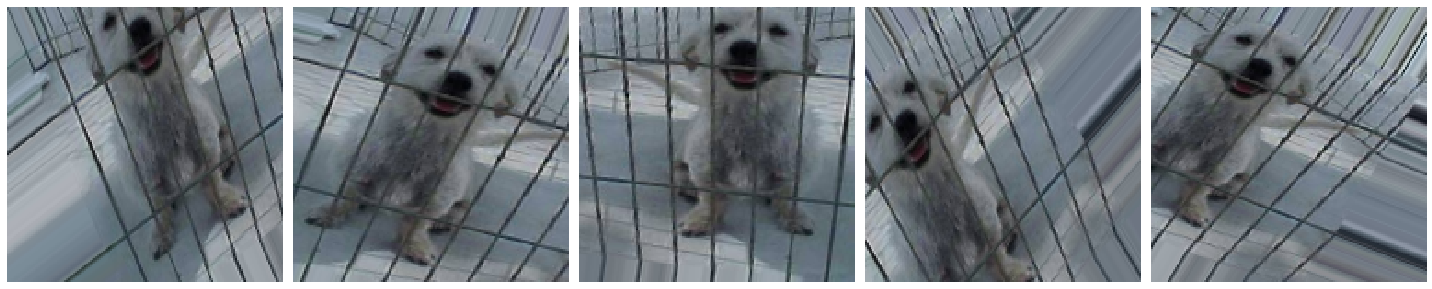

In [10]:
sample_aug_images, _ = next(train_aug_data_gen)
plot_images([train_aug_data_gen[0][0][0] for i in range(5)])

In [19]:
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    
    Conv2D(256, 3, activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    
    Flatten(),
    
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 128)      

In [23]:
history = model.fit_generator(train_aug_data_gen,
                   steps_per_epoch=150,
                   epochs=35,
                   validation_data=val_aug_data_gen,
                   validation_steps=50,
                   verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 150 steps, validate for 50 steps
Epoch 1/10
150/150 [==============================] - 132s 879ms/step - loss: 0.5284 - accuracy: 0.7385 - val_loss: 0.5733 - val_accuracy: 0.6931
Epoch 2/10
150/150 [==============================] - 150s 999ms/step - loss: 0.5212 - accuracy: 0.7410 - val_loss: 0.5368 - val_accuracy: 0.7344
Epoch 3/10
150/150 [==============================] - 155s 1s/step - loss: 0.5187 - accuracy: 0.7452 - val_loss: 0.5126 - val_accuracy: 0.7437
Epoch 4/10
150/150 [==============================] - 144s 957ms/step - loss: 0.5208 - accuracy: 0.7435 - val_loss: 0.5234 - val_accuracy: 0.7337
Epoch 5/10
150/150 [==============================] - 139s 928ms/step - loss: 0.5278 - accuracy: 0.7328 - val_loss: 0.5427 - val_accuracy: 0.7138
Epoch 6/10
150/150 [==============================] - 139s 925ms/step - loss: 0.4893 - accuracy: 0.7640 - val_loss: 0.5131 - val_accuracy: 0.7538
Epoch 7/10
150/150 [==============

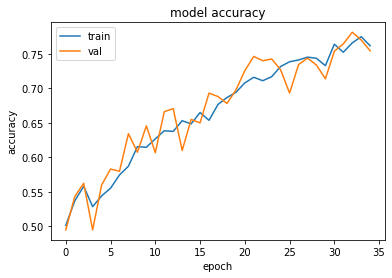

  ...
    to  
  ['...']
125/125 [==============================] - 22s 178ms/step - loss: 0.3863 - accuracy: 0.8325s - loss: 0.3898 - 


[0.38632680773735045, 0.8325]

In [25]:
plot_history(history)
model.evaluate(test_data_gen)

# Existing networks

In [27]:
from tensorflow.keras import Model

vgg_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, 
                                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

for layer in vgg_base.layers[:5]:
    layer.trainable = False
    
x = vgg_base.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(25, activation="softmax")(x)

vgg_model = Model(vgg_base.input, predictions)

vgg_model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [28]:
history = vgg_model.fit_generator(
    train_data_gen, 
    epochs=2,
    validation_data=val_data_gen, 
    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 594 steps, validate for 63 steps
Epoch 1/2
594/594 [==============================] - 4382s 7s/step - loss: 0.2876 - accuracy: 0.8729 - val_loss: 0.0977 - val_accuracy: 0.9610
Epoch 2/2
594/594 [==============================] - 4361s 7s/step - loss: 0.0816 - accuracy: 0.9675 - val_loss: 0.1019 - val_accuracy: 0.9585


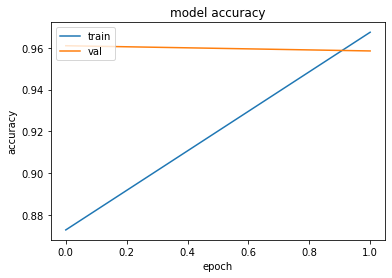

  ...
    to  
  ['...']
125/125 [==============================] - 266s 2s/step - loss: 0.0955 - accuracy: 0.9650


[0.0954750454891473, 0.965]

In [30]:
plot_history(history)
vgg_model.evaluate(test_data_gen)